Install the required settings and libraries

In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
print("RAM:", torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else "N/A")

GPU Available: True
GPU Name: Tesla T4
RAM: 15.637086208


In [ ]:
# Install all required libraries
!pip install transformers
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pandas numpy Pillow scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t4ibpplk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t4ibpplk
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=c0230eedac715a0d22428751368e81c9b2680ceaa7f8014d96cf72696a1dca05
  Stored in directory: /tmp/pip-ephem-wheel-cache-pt0x4rnu/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
import torch
import clip
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("All imports successful! ✅")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

All imports successful! ✅
Using device: cuda


In [ ]:
from google.colab import files
files.upload()

Saving kaggles.json to kaggles.json


{'kaggles.json': b'{"username":"rishikaranyal","key":"264118780cd00493a7a305ca2358c880"}'}

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import os, json

IMG_DIR = "/content/drive/MyDrive/Hate/img"          # <-- your image folder
IN_JSON = "/content/drive/MyDrive/Hate/train.jsonl"  # <-- path to train.jsonl
OUT_JSON = "/content/drive/MyDrive/Hate/train_small.jsonl"

kept = 0
with open(IN_JSON, "r") as fin, open(OUT_JSON, "w") as fout:
    for line in fin:
        sample = json.loads(line)
        img_path = os.path.join(IMG_DIR, sample["img"])
        if os.path.exists(img_path):
            fout.write(json.dumps(sample) + "\n")
            kept += 1

print(f"Done. Kept {kept} samples that have images.")

Done. Kept 898 samples that have images.


In [90]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json, os
import clip, torch
from PIL import Image, UnidentifiedImageError

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

class HatefulMemesDataset(Dataset):
    def __init__(self, jsonl_path, img_dir, preprocess, tokenizer):
        self.samples = []
        with open(jsonl_path, "r") as f:
            for line in f:
                self.samples.append(json.loads(line))
        self.img_dir = img_dir
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img_path = os.path.join(self.img_dir, s["img"])

        try:
            image = Image.open(img_path).convert("RGB")
            image = self.preprocess(image)
        except (UnidentifiedImageError, OSError) as e:
            # ⚠️ Broken image: pick another random sample
            new_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(new_idx)

        text  = self.tokenizer([s["text"]], truncate=True)[0]
        label = int(s["label"])
        return {"image": image, "text": text, "label": label}

train_ds = HatefulMemesDataset(
    jsonl_path=OUT_JSON ,
    img_dir=IMG_DIR,
    preprocess=preprocess,
    tokenizer=clip.tokenize
)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

batch = next(iter(train_loader))
print(batch["image"].shape, batch["text"].shape, batch["label"])

torch.Size([4, 3, 224, 224]) torch.Size([4, 77]) tensor([1, 1, 0, 1])


In [91]:
import torch.nn as nn

class CLIPHatefulClassifier(nn.Module):
  def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),  # 512 image + 512 text for ViT-B/32
            nn.ReLU(),
            nn.Linear(256, 2)
        )

        # Freeze CLIP
        for p in self.clip.parameters():
            p.requires_grad = False
        self.clip.eval()

  def forward(self, images, texts):
    with torch.no_grad():
        img_f = self.clip.encode_image(images)
        txt_f = self.clip.encode_text(texts)

    # 🔁 Convert to float32 (fix dtype mismatch)
    img_f = img_f.float()
    txt_f = txt_f.float()

    # Normalise
    img_f = img_f / img_f.norm(dim=-1, keepdim=True).clamp(min=1e-6)
    txt_f = txt_f / txt_f.norm(dim=-1, keepdim=True).clamp(min=1e-6)

    feats = torch.cat([img_f, txt_f], dim=1)
    out = self.classifier(feats)
    return out

model = CLIPHatefulClassifier(clip_model).to(device)

In [92]:
batch = next(iter(train_loader))
images = batch["image"].to(device)
texts  = batch["text"].to(device)

with torch.no_grad():
    logits = model(images, texts)

print(logits.shape)

torch.Size([4, 2])


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-e5aabfd7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-e5aabfd7
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done


In [93]:
import torch.nn.functional as F
from tqdm import tqdm

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc="Training"):
        images = batch["image"].to(device)
        texts  = batch["text"].to(device)
        labels = batch["label"].long().to(device)

        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.classifier.parameters(), 1.0)
        optimizer.step()

        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
        total_loss += loss.item()

    return total_loss / len(loader), 100 * correct / total

train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

Training: 100%|██████████| 225/225 [04:29<00:00,  1.20s/it]

Train Loss: 0.6750 | Train Acc: 61.58%


In [95]:
from sklearn.metrics import precision_recall_fscore_support

def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            images = batch["image"].to(device)
            texts  = batch["text"].to(device)
            labels = batch["label"].long().to(device)

            outputs = model(images, texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = outputs.max(1)

            correct += (preds == labels).sum().item()
            total   += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(loader)
    val_acc  = 100 * correct / total

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="binary"
    )

    return val_loss, val_acc, precision, recall, f1

In [96]:
num_epochs = 5
best_f1 = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, precision, recall, f1 = validate_epoch(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print(f"Precision:  {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_clip_hateful.pt")
        print("💾 Best model saved!")


Epoch 1/5


Validating: 100%|██████████| 13/13 [00:39<00:00,  3.07s/it]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.6477 | Train Acc: 62.58%
Val   Loss: 0.7704 | Val   Acc: 35.50%
Precision:  0.000 | Recall: 0.000 | F1: 0.000

Epoch 2/5


Validating: 100%|██████████| 13/13 [00:38<00:00,  2.95s/it]


Train Loss: 0.6196 | Train Acc: 64.59%
Val   Loss: 0.7824 | Val   Acc: 38.00%
Precision:  1.000 | Recall: 0.039 | F1: 0.075
💾 Best model saved!

Epoch 3/5


Validating: 100%|██████████| 13/13 [00:32<00:00,  2.50s/it]


Train Loss: 0.5882 | Train Acc: 69.04%
Val   Loss: 0.7881 | Val   Acc: 42.00%
Precision:  0.882 | Recall: 0.116 | F1: 0.205
💾 Best model saved!

Epoch 4/5


Validating: 100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


Train Loss: 0.5537 | Train Acc: 72.16%
Val   Loss: 0.7854 | Val   Acc: 44.50%
Precision:  0.875 | Recall: 0.163 | F1: 0.275
💾 Best model saved!

Epoch 5/5


Validating: 100%|██████████| 13/13 [00:37<00:00,  2.85s/it]


Train Loss: 0.5229 | Train Acc: 74.50%
Val   Loss: 0.7895 | Val   Acc: 47.50%
Precision:  0.853 | Recall: 0.225 | F1: 0.356
💾 Best model saved!


In [97]:
import os, json

IN_JSON = "/content/drive/MyDrive/Hate/test.jsonl"
OUT_JSON = "/content/drive/MyDrive/Hate/test_small.jsonl"

kept = 0
with open(IN_JSON, "r") as fin, open(OUT_JSON, "w") as fout:
    for line in fin:
        sample = json.loads(line)
        img_path = os.path.join(IMG_DIR, sample["img"])
        if os.path.exists(img_path):
            fout.write(json.dumps(sample) + "\n")
            kept += 1

print(f"Kept {kept} test samples that have images.")

Kept 104 test samples that have images.


In [98]:
test_ds = HatefulMemesDataset(
    jsonl_path=OUT_JSON,
    img_dir=IMG_DIR,
    preprocess=preprocess,
    tokenizer=clip.tokenize
)

test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

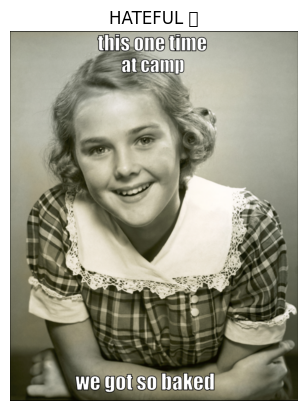

Meme Text:
muslim wife wearing sexy lingerie for her husband

Model Prediction: HATEFUL ❌


In [137]:
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
import json
import os

# 1) Load best model
model.load_state_dict(torch.load("best_clip_hateful.pt", map_location=device))
model.eval()

# 2) Load test_small.jsonl
test_json = OUT_JSON
img_dir   = IMG_DIR

samples = []
with open(test_json, "r") as f:
    for line in f:
        samples.append(json.loads(line))

# 3) Pick random sample
sample = random.choice(samples)

img_path = os.path.join(img_dir, sample["img"])
text = sample["text"]

# 4) Load + preprocess image
image_pil = Image.open(img_path).convert("RGB")
image_tensor = preprocess(image_pil).unsqueeze(0).to(device)
text_tensor  = clip.tokenize([text], truncate=True).to(device)

# 5) Predict
with torch.no_grad():
    logits = model(image_tensor, text_tensor)
    pred = logits.argmax(dim=1).item()

label_str = "HATEFUL ❌" if pred == 1 else "NOT HATEFUL ✅"

# 6) Show result
plt.imshow(image_pil)
plt.axis("off")
plt.title(label_str)
plt.show()

print("Meme Text:")
print(text)
print("\nModel Prediction:", label_str)